In [1]:
import tensorflow as tf
from tensorflow import keras

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import pickle

def load_traffic_sign_data(training_file, testing_file):
    with open(training_file, mode='rb') as f:
        train = pickle.load(f)
    with open(testing_file, mode='rb') as f:
        test = pickle.load(f)
    return train, test

# path for training and testing files
training_file = r"/content/drive/MyDrive/traffic_sign_dataset/train.p"
testing_file = r"/content/drive/MyDrive/traffic_sign_dataset/test.p"

# Load pickled data using the correct file paths
train, test = load_traffic_sign_data(training_file, testing_file)

# Extract features and labels
X_train, y_train = train['features'], train['labels']
X_test, y_test = test['features'], test['labels']


In [4]:
import numpy as np
#number of examples
n_train,n_test=X_train.shape[0],X_test.shape[0]
#shape
image_shape=X_train[0].shape
#how many classes?
n_classes=np.unique(y_train).shape[0]
print("number of training examples:",n_train)
print("number of testing examples:",n_test)
print("Image data shape=",image_shape)
print("number of classes",n_classes)

number of training examples: 34799
number of testing examples: 12630
Image data shape= (32, 32, 3)
number of classes 43


In [5]:
print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")

X_train shape: (34799, 32, 32, 3)
y_train shape: (34799,)


In [6]:
X_train, y_train = train['features'], train['labels']


In [7]:
min_samples = min(X_train.shape[0], y_train.shape[0])
X_train = X_train[:min_samples]
y_train = y_train[:min_samples]
print(f"Aligned shapes: X_train={X_train.shape}, y_train={y_train.shape}")


Aligned shapes: X_train=(34799, 32, 32, 3), y_train=(34799,)


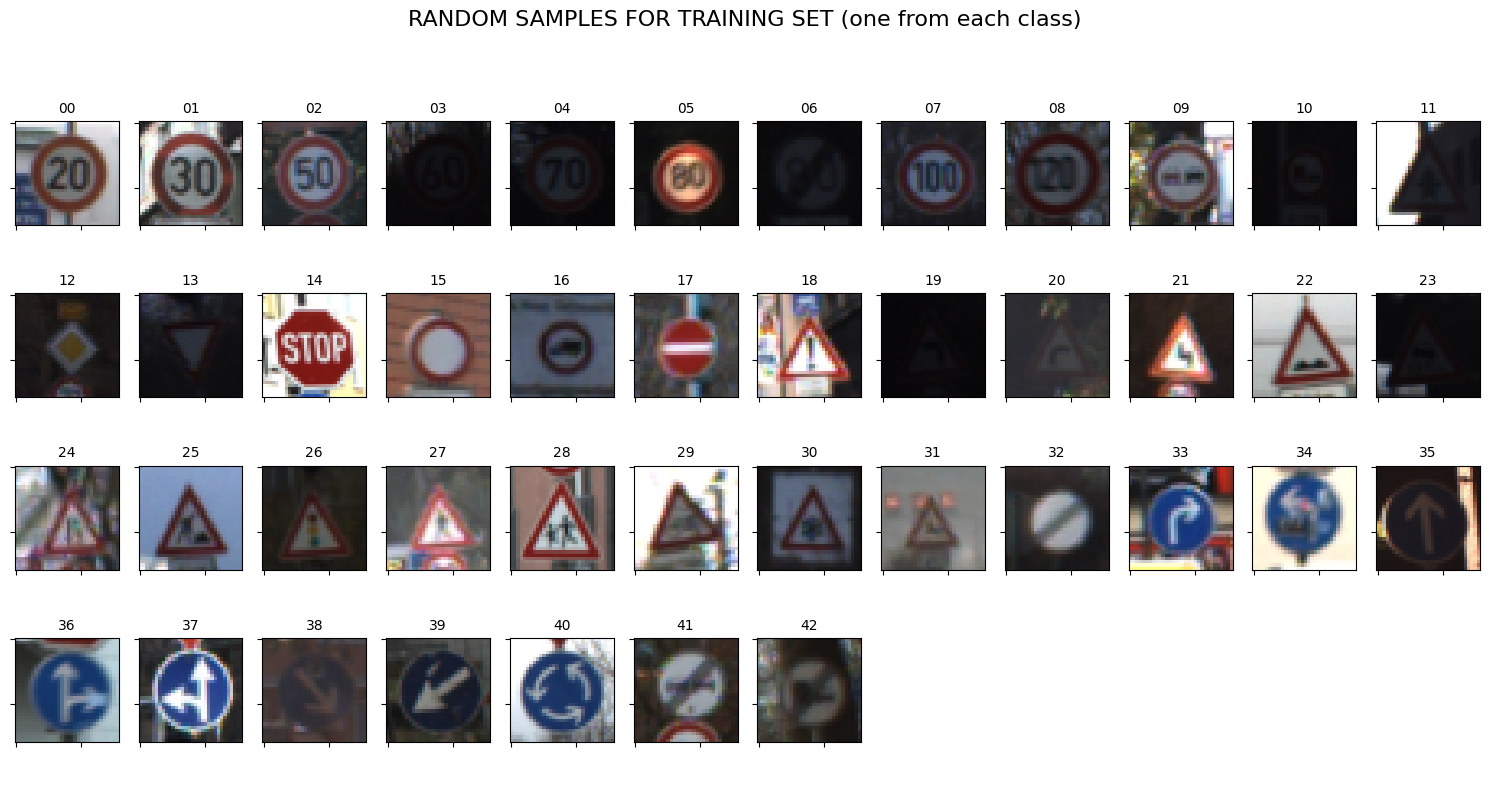

In [8]:
import matplotlib.pyplot as plt
import numpy as np

# Ensure y_train is a numpy array
y_train = np.array(y_train)

# Ensure shapes of X_train and y_train match
assert X_train.shape[0] == y_train.shape[0], "Mismatch between X_train and y_train sizes"

# Random sampling for each traffic sign dataset
rows, cols = 4, 12
fig, ax_array = plt.subplots(rows, cols, figsize=(15, 8))
fig.suptitle('RANDOM SAMPLES FOR TRAINING SET (one from each class)', fontsize=16)

for class_idx, ax in enumerate(ax_array.ravel()):
    if class_idx < n_classes:
        # Get indices for the current class
        class_indices = np.where(y_train == class_idx)[0]

        # Skip missing classes
        if len(class_indices) == 0:
            ax.axis('off')
            continue

        # Randomly select one image from the current class
        random_index = np.random.choice(class_indices)
        cur_img = X_train[random_index]

        # Plot the image
        ax.imshow(cur_img)
        ax.set_title('{:02d}'.format(class_idx), fontsize=10)
    else:
        ax.axis('off')

# Hide both x and y ticks
plt.setp([a.get_xticklabels() for a in ax_array.ravel()], visible=False)
plt.setp([a.get_yticklabels() for a in ax_array.ravel()], visible=False)

# Adjust layout to avoid overlap and leave space for the title
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

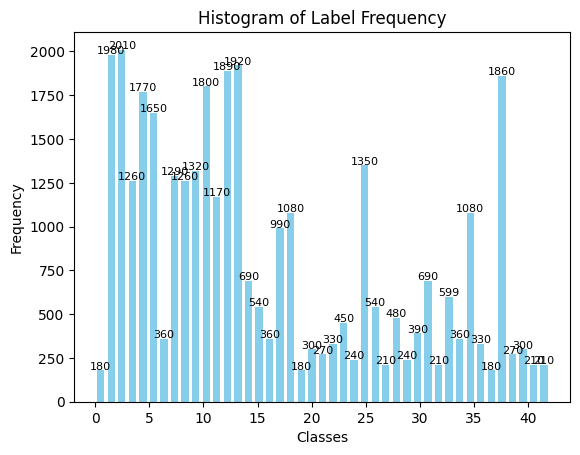

In [9]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming y_train and n_classes are defined
# Histogram of label frequency
hist, bins = np.histogram(y_train, bins=n_classes)
width = 0.7 * (bins[1] - bins[0])
center = (bins[:-1] + bins[1:]) / 2

plt.bar(center, hist, align='center', width=width, color='skyblue')  # Updated color
plt.xlabel("Classes")
plt.ylabel("Frequency")
plt.title("Histogram of Label Frequency")

# Display frequencies above bars
for i, v in enumerate(hist):
    plt.text(center[i], v + 5, str(v), ha='center', fontsize=8)

# Adjust x-axis ticks for readability
plt.xticks(np.arange(0, n_classes, step=5))  # Show ticks every 5 classes

plt.show()


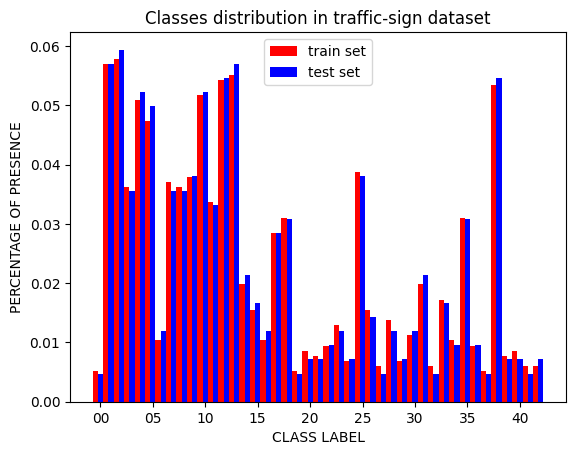

In [10]:

# bar-chart of classes distribution
train_distribution, test_distribution = np.zeros(n_classes), np.zeros(n_classes)
for c in range(n_classes):
    train_distribution[c] = np.sum(y_train == c) / n_train
    test_distribution[c] = np.sum(y_test == c) / n_test
fig, ax = plt.subplots()
col_width = 0.5
bar_train = ax.bar(np.arange(n_classes), train_distribution, width=col_width, color='r')
bar_test = ax.bar(np.arange(n_classes)+col_width, test_distribution, width=col_width, color='b')
ax.set_ylabel('PERCENTAGE OF PRESENCE')
ax.set_xlabel('CLASS LABEL')
ax.set_title('Classes distribution in traffic-sign dataset')
ax.set_xticks(np.arange(0, n_classes, 5)+col_width)
ax.set_xticklabels(['{:02d}'.format(c) for c in range(0, n_classes, 5)])
ax.legend((bar_train[0], bar_test[0]), ('train set', 'test set'))
plt.show()

In [11]:
import cv2
import numpy as np

def preprocess_features(X, equalize_hist=True):
    # Validate input shape
    assert X.ndim == 4 and X.shape[-1] == 3, "Input images must be in (num_samples, height, width, 3) format"

    # Convert from RGB to YUV and extract luminance channel
    X_yuv = np.array([cv2.cvtColor(rgb_img, cv2.COLOR_RGB2YUV)[:, :, 0] for rgb_img in X])

    # Adjust image contrast (equalize histogram)
    if equalize_hist:
        X_yuv = np.array([cv2.equalizeHist(np.uint8(img)) for img in X_yuv])

    # Add channel dimension back after processing
    X_yuv = np.expand_dims(X_yuv, axis=-1)

    # Standardize features
    X_yuv = X_yuv.astype(np.float32)
    X_yuv -= np.mean(X_yuv, axis=0)
    X_yuv /= (np.std(X_yuv, axis=0) + np.finfo('float32').eps)

    return X_yuv

# Normalize training and testing datasets
X_train_norm = preprocess_features(X_train)
X_test_norm = preprocess_features(X_test)


In [12]:
print(f"X_train_norm shape: {X_train_norm.shape}")
print(f"X_test_norm shape: {X_test_norm.shape}")
print(f"Mean: {np.mean(X_train_norm):.2f}, Std: {np.std(X_train_norm):.2f}")


X_train_norm shape: (34799, 32, 32, 1)
X_test_norm shape: (12630, 32, 32, 1)
Mean: 0.00, Std: 1.00


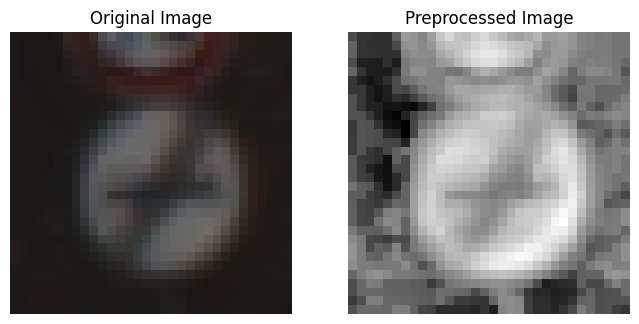

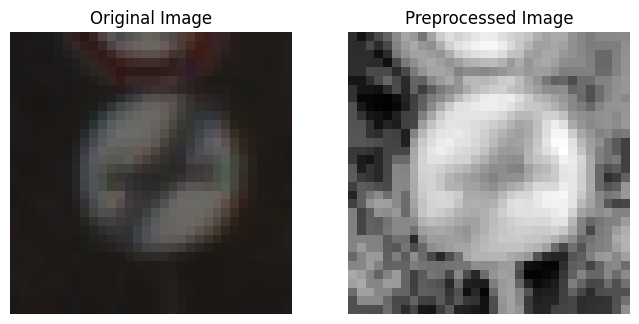

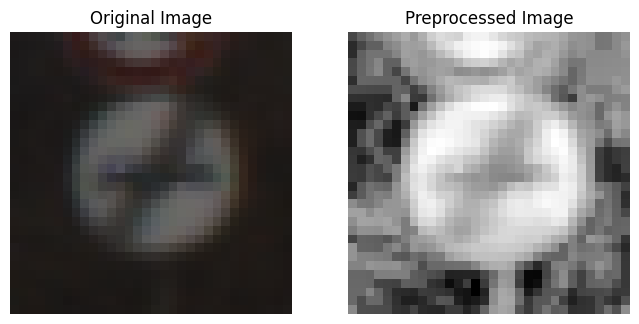

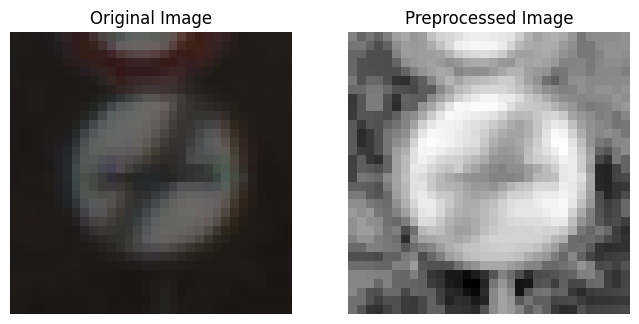

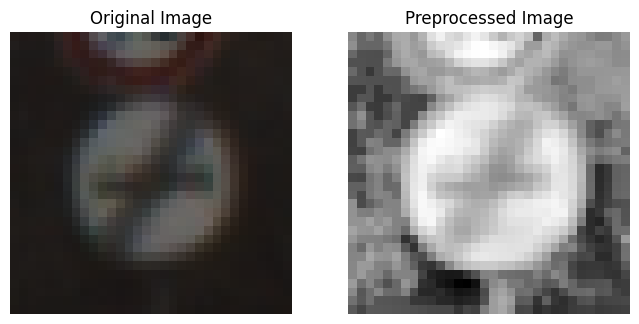

In [13]:
import matplotlib.pyplot as plt
# Display a few original and normalized images
for i in range(5):
    plt.figure(figsize=(8, 4))

    # Original image
    plt.subplot(1, 2, 1)
    plt.imshow(X_train[i])
    plt.title("Original Image")
    plt.axis('off')

    # Preprocessed image
    plt.subplot(1, 2, 2)
    plt.imshow(X_train_norm[i].squeeze(), cmap='gray')
    plt.title("Preprocessed Image")
    plt.axis('off')

    plt.show()


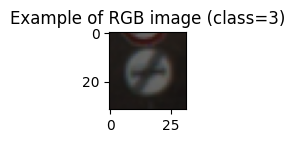

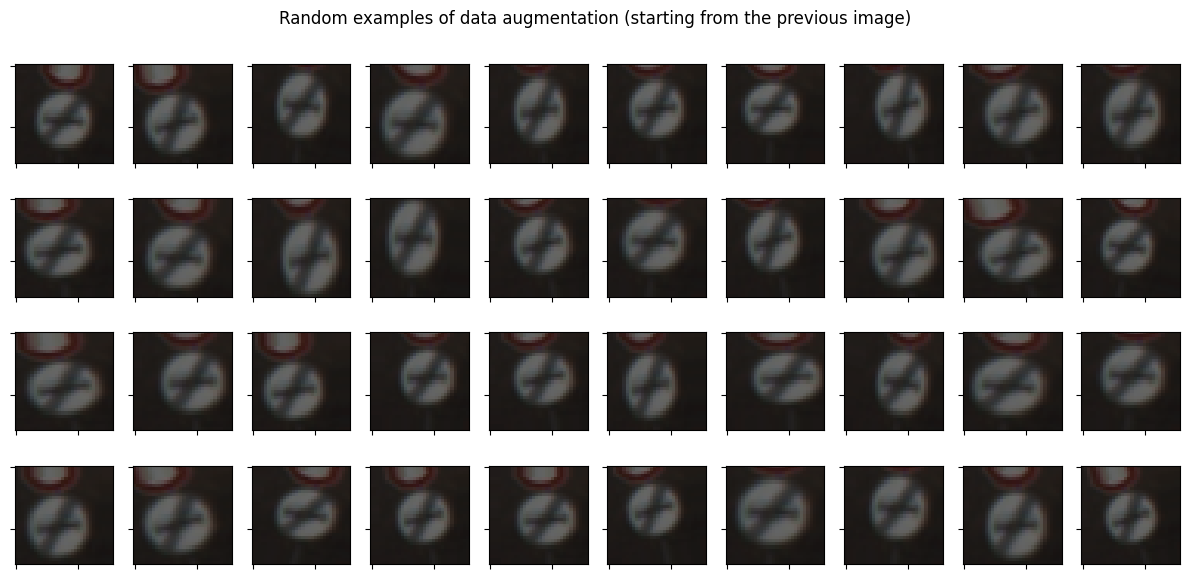

In [14]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import numpy as np

# Split into train and validation
VAL_RATIO = 0.2
X_train_norm, X_val_norm, y_train, y_val = train_test_split(X_train_norm, y_train, test_size=VAL_RATIO, random_state=0)

# Create the generator to perform the online data augmentation
image_datagen = ImageDataGenerator(
    rotation_range=15.0,
    zoom_range=0.2,
    width_shift_range=0.1,
    height_shift_range=0.1
)

# Take a random image from the training set
img_rgb = X_train[10]

# Plot the original image
plt.figure(figsize=(1, 1))
plt.imshow(img_rgb)
plt.title('Example of RGB image (class={})'.format(y_train[0]))
plt.show()

# Plot some randomly augmented images
rows, cols = 4, 10
fig, ax_array = plt.subplots(rows, cols, figsize=(12, 6))
for ax in ax_array.ravel():
    augmented_img, _ = next(image_datagen.flow(np.expand_dims(img_rgb, 0), np.array([y_train[0]])))
    ax.imshow(np.uint8(np.squeeze(augmented_img)))

# Hide axis labels
plt.setp([a.get_xticklabels() for a in ax_array.ravel()], visible=False)
plt.setp([a.get_yticklabels() for a in ax_array.ravel()], visible=False)
plt.suptitle('Random examples of data augmentation (starting from the previous image)')
plt.tight_layout()
plt.show()


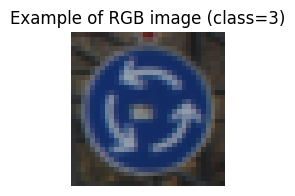

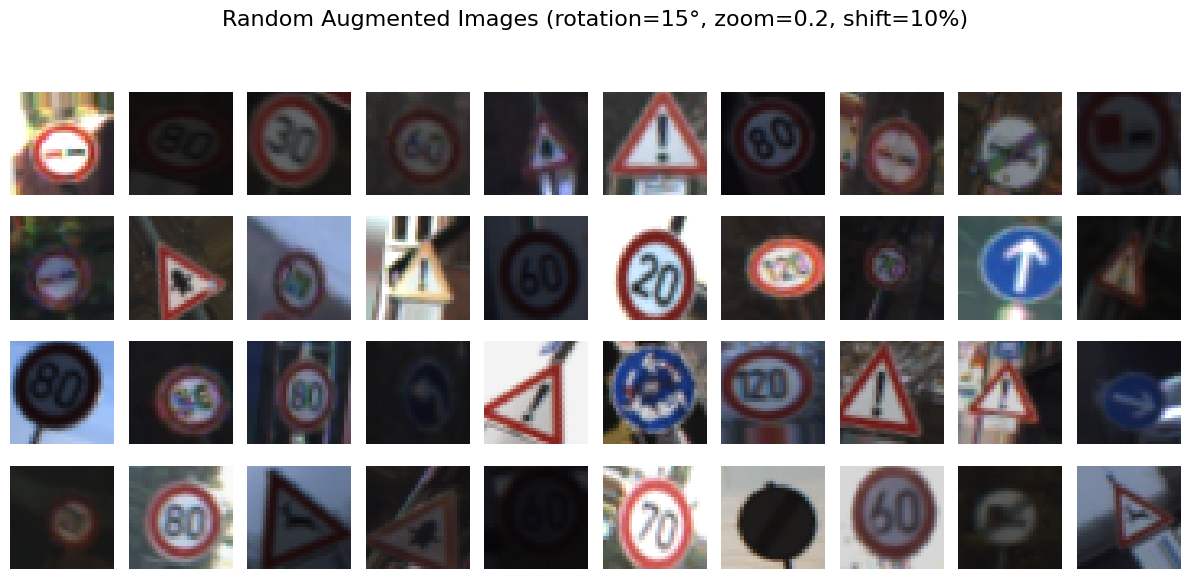

In [15]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import numpy as np

# Split into train and validation (with stratification for balanced validation data)
VAL_RATIO = 0.2
X_train_norm, X_val_norm, y_train, y_val = train_test_split(
    X_train_norm, y_train, test_size=VAL_RATIO, random_state=0, stratify=y_train
)

# Create the generator to perform the online data augmentation
image_datagen = ImageDataGenerator(
    rotation_range=30.0,
    zoom_range=0.2,
    shear_range=0.2,
    brightness_range=[0.8, 1.2],
    width_shift_range=0.1,
    height_shift_range=0.1
)

# Display a random original image from the training set
random_index = np.random.randint(len(X_train_norm))  # Use the new size of X_train_norm
img_rgb = X_train[random_index]  # Original image (before normalization)

plt.figure(figsize=(2, 2))
plt.imshow(img_rgb)
plt.title(f'Example of RGB image (class={y_train[random_index]})')
plt.axis('off')
plt.show()

# Plot some randomly augmented images (from different samples)
rows, cols = 4, 10
fig, ax_array = plt.subplots(rows, cols, figsize=(12, 6))
for ax in ax_array.ravel():
    random_index = np.random.randint(len(X_train_norm))  # Use the new size of X_train_norm
    img_rgb = X_train[random_index]  # Original image (before normalization)
    augmented_img, _ = next(image_datagen.flow(
        np.expand_dims(img_rgb, 0), np.array([y_train[random_index]])
    ))
    ax.imshow(np.uint8(np.squeeze(augmented_img)))
    ax.axis('off')  # Hide axis labels

# Set the title and adjust the layout
plt.suptitle('Random Augmented Images (rotation=15°, zoom=0.2, shift=10%)', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


In [16]:
print(f"Training set size: {len(X_train_norm)}")
print(f"Validation set size: {len(X_val_norm)}")


Training set size: 22271
Validation set size: 5568


In [17]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input
from tensorflow.keras.models import Model

# Define the network architecture
def my_net(input_shape, n_classes):
    inputs = Input(shape=input_shape)

    # First convolutional layer
    x = Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same')(inputs)
    x = MaxPooling2D(pool_size=(2, 2), padding='same')(x)  # 🔹 Max pooling layer
    x = Dropout(0.3)(x)

    # Second convolutional layer
    x = Conv2D(filters=128, kernel_size=(3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D(pool_size=(2, 2), padding='same')(x)  # 🔹 Max pooling layer
    x = Dropout(0.3)(x)

    # Third convolutional layer
    x = Conv2D(filters=256, kernel_size=(3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D(pool_size=(2, 2), padding='same')(x)  # 🔹 Max pooling layer
    x = Dropout(0.3)(x)

    # Flatten the output
    x = Flatten()(x)

    # Fully connected layers
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.3)(x)

    x = Dense(64, activation='relu')(x)
    x = Dropout(0.3)(x)

    # Output layer
    outputs = Dense(n_classes, activation='softmax')(x)

    # Create model
    model = Model(inputs=inputs, outputs=outputs)
    return model

# Define parameters
input_shape = (32, 32, 1)
n_classes = 43  # Example number of classes

# Create the model
model = my_net(input_shape, n_classes)

# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Print model summary
model.summary()

# Function to evaluate the model
def evaluate(model, X_data, y_data):
    loss, accuracy = model.evaluate(X_data, y_data, verbose=0)
    return accuracy

# Saving the model weights
checkpoint_path = "traffic1.weights.h5"
model.save_weights(checkpoint_path)

print("Model saved successfully at:", checkpoint_path)


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 32, 32, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 32, 32, 64)          │             640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 16, 16, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 16, 16, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 16, 16, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 8, 8, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 8, 8, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 8, 8, 256)           │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 4, 4, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 4, 4, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 4096)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │         524,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 43)                  │           2,795 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 905,131 (3.45 MB)

 Trainable params: 905,131 (3.45 MB)

 Non-trainable params: 0 (0.00 B)

Model saved successfully at: traffic1.weights.h5


In [18]:
BATCHSIZE = 128
EPOCHS = 50
BATCHES_PER_EPOCH = len(X_train_norm) // BATCHSIZE  # Correct Calculation


In [19]:
# Train the model using Keras API
history = model.fit(
    image_datagen.flow(X_train_norm, y_train, batch_size=BATCHSIZE),
    epochs=EPOCHS,
    steps_per_epoch=BATCHES_PER_EPOCH,
    validation_data=(X_val_norm, y_val)
)

# Save trained weights after training completes
model.save_weights("traffic1.weights.h5")

print("Model training complete. Weights saved successfully.")


Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


173/173 ━━━━━━━━━━━━━━━━━━━━ 29s 114ms/step - accuracy: 0.0593 - loss: 3.6164 - val_accuracy: 0.1810 - val_loss: 3.0554
Epoch 2/50
  1/173 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.1562 - loss: 3.1180

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


173/173 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.1562 - loss: 3.1180 - val_accuracy: 0.1782 - val_loss: 3.0594
Epoch 3/50
173/173 ━━━━━━━━━━━━━━━━━━━━ 13s 77ms/step - accuracy: 0.1620 - loss: 3.1141 - val_accuracy: 0.4661 - val_loss: 1.9769
Epoch 4/50
173/173 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.2969 - loss: 2.5086 - val_accuracy: 0.4729 - val_loss: 1.9770
Epoch 5/50
173/173 ━━━━━━━━━━━━━━━━━━━━ 14s 79ms/step - accuracy: 0.3136 - loss: 2.4269 - val_accuracy: 0.5607 - val_loss: 1.4670
Epoch 6/50
173/173 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.3906 - loss: 2.1126 - val_accuracy: 0.5621 - val_loss: 1.4671
Epoch 7/50
173/173 ━━━━━━━━━━━━━━━━━━━━ 20s 80ms/step - accuracy: 0.4017 - loss: 1.9924 - val_accuracy: 0.6388 - val_loss: 1.1816
Epoch 8/50
173/173 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4531 - loss: 1.7445 - val_accuracy: 0.6397 - val_loss: 1.1696
Epoch 9/50
173/173 ━━━━━━━━━━━━━━━━━━━━ 14s 82ms/step - accuracy: 0.4585 - loss: 1.7524 - val_accuracy: 0.692

In [23]:

# Optionally: Make Predictions on Test Set
y_pred = model.predict(X_test_norm)
y_pred_classes = np.argmax(y_pred, axis=1)  # Convert softmax probabilities to class labels

# Print some predictions
print("Sample Predictions:", y_pred_classes[:10])
print("Actual Labels:", y_test[:10])


395/395 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step
Sample Predictions: [16  1 38 33 11 38 18 12 25 35]
Actual Labels: [16  1 38 33 11 38 18 12 25 35]


Shape of images: (4410, 32, 32, 3), Data type: uint8


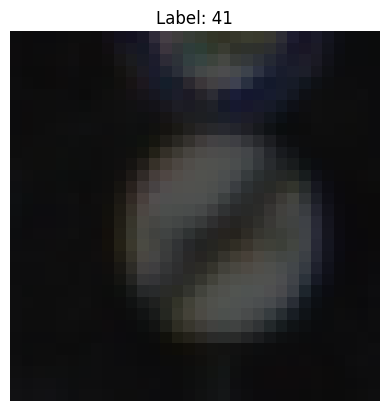

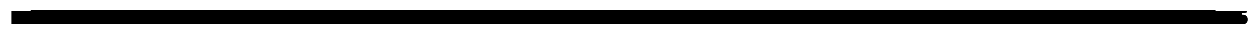

In [25]:
import pickle
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load the pickle file directly
new_images_file = r'/content/drive/MyDrive/traffic_sign_dataset/valid.p'

# Load the dataset (assuming it's in the same format as train/test)
with open(new_images_file, 'rb') as f:
    valid_data = pickle.load(f)

# Extract features (images) and labels
new_test_images = np.array(valid_data['features'])  # Assuming images are stored in 'features'
new_targets = valid_data['labels']  # Assuming labels are stored in 'labels'

# Check data shape
print(f"Shape of images: {new_test_images.shape}, Data type: {new_test_images.dtype}")

# Normalize if necessary
if new_test_images.max() > 1:
    new_test_images = new_test_images.astype(np.float32) / 255.0

# Convert to RGB only if needed
if new_test_images.shape[-1] == 3:
    new_test_images = np.array([cv2.cvtColor(img, cv2.COLOR_BGR2RGB) for img in new_test_images])

# Display a single test image before plotting all
plt.imshow(new_test_images[0])
plt.title(f"Label: {new_targets[0]}")
plt.axis('off')
plt.show()

# Plot all test images
fig, axarray = plt.subplots(1, len(new_test_images), figsize=(15, 5))
for i, ax in enumerate(axarray.ravel()):
    ax.imshow(new_test_images[i])
    ax.set_title(f'Label: {new_targets[i]}')
    ax.axis('off')

plt.show()


In [26]:
import numpy as np
import tensorflow as tf

# First: Feature Preprocessing
new_test_images_norm = preprocess_features(new_test_images)  # Ensure this function is defined correctly

# Predict on new images using trained model
y_pred_probs = model.predict(new_test_images_norm)  # Get softmax probabilities
predictions = np.argmax(y_pred_probs, axis=1)  # Convert to class labels

# Print the results in the desired format
for i, pred in enumerate(predictions):
    print(f'Image {i} - Target = {new_targets[i]:02d}, Predicted = {pred:02d}')

# Calculate and print model accuracy
accuracy = np.mean(np.array(new_targets) == predictions)
print(f'> Model accuracy: {accuracy:.2f}')


138/138 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
Image 0 - Target = 41, Predicted = 05
Image 1 - Target = 41, Predicted = 05
Image 2 - Target = 41, Predicted = 05
Image 3 - Target = 41, Predicted = 05
Image 4 - Target = 41, Predicted = 05
Image 5 - Target = 41, Predicted = 05
Image 6 - Target = 41, Predicted = 05
Image 7 - Target = 41, Predicted = 05
Image 8 - Target = 41, Predicted = 05
Image 9 - Target = 41, Predicted = 05
Image 10 - Target = 41, Predicted = 05
Image 11 - Target = 41, Predicted = 05
Image 12 - Target = 41, Predicted = 05
Image 13 - Target = 41, Predicted = 05
Image 14 - Target = 41, Predicted = 05
Image 15 - Target = 41, Predicted = 05
Image 16 - Target = 41, Predicted = 05
Image 17 - Target = 41, Predicted = 05
Image 18 - Target = 41, Predicted = 05
Image 19 - Target = 41, Predicted = 05
Image 20 - Target = 41, Predicted = 05
Image 21 - Target = 41, Predicted = 05
Image 22 - Target = 41, Predicted = 05
Image 23 - Target = 41, Predicted = 05
Image 24 - Target = 41, Predicted

In [27]:
test_loss, test_accuracy = model.evaluate(X_test_norm, y_test, verbose=1)
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test Loss: {test_loss:.4f}")


395/395 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9247 - loss: 0.2652
Test Accuracy: 0.9240
Test Loss: 0.2661


In [28]:
y_pred_probs = model.predict(X_test_norm)
y_pred_classes = np.argmax(y_pred_probs, axis=1)

# Compare predictions with actual labels
for i in range(10):
    print(f"Actual: {y_test[i]}, Predicted: {y_pred_classes[i]}")


395/395 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Actual: 16, Predicted: 16
Actual: 1, Predicted: 1
Actual: 38, Predicted: 38
Actual: 33, Predicted: 33
Actual: 11, Predicted: 11
Actual: 38, Predicted: 38
Actual: 18, Predicted: 18
Actual: 12, Predicted: 12
Actual: 25, Predicted: 25
Actual: 35, Predicted: 35


In [29]:
model.save("final_traffic_sign_model.h5")
print("Model saved successfully!")


Model saved successfully!


In [31]:
import numpy as np

# Preprocess new test images
new_test_images_norm = preprocess_features(new_test_images)

# Predict on new images using trained model
y_pred_probs = model.predict(new_test_images_norm)  # Get softmax probabilities
y_pred_classes = np.argmax(y_pred_probs, axis=1)  # Convert to class labels

# Print only the first 5 predictions in required format
for i in range(5):  # Only show first 5 images
    print(f'Image {i} - Target = {new_targets[i]:02d}, Predicted = {y_pred_classes[i]:02d}')

# Calculate and print model accuracy
accuracy = np.mean(np.array(new_targets[:30]) == y_pred_classes[:30])  # Only consider first 5 images
print(f'> Model accuracy: {accuracy:.2f}')


138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Image 0 - Target = 41, Predicted = 05
Image 1 - Target = 41, Predicted = 05
Image 2 - Target = 41, Predicted = 05
Image 3 - Target = 41, Predicted = 05
Image 4 - Target = 41, Predicted = 05
> Model accuracy: 0.00


In [32]:
import numpy as np
import matplotlib.pyplot as plt

# Set top-K predictions
K = 3

# Compute softmax probabilities
y_pred_probs = model.predict(new_test_images_norm)  # Get softmax probabilities

# Get top K predictions
top_K_indices = np.argsort(y_pred_probs, axis=1)[:, -K:][:, ::-1]  # Get top 3 indices sorted in descending order

# Plot softmax probabilities along with traffic sign images
n_images = new_test_images_norm.shape[0]
fig, axarray = plt.subplots(n_images, 2, figsize=(8, 2 * n_images))
plt.suptitle('Visualization of Softmax Probabilities for Each Example', fontweight='bold')

for r in range(n_images):
    axarray[r, 0].imshow(np.squeeze(new_test_images[r]))
    axarray[r, 0].axis('off')  # Remove axis labels
    axarray[r, 1].bar(np.arange(len(y_pred_probs[r])), y_pred_probs[r])
    axarray[r, 1].set_ylim([0, 1])  # Set probability range

plt.tight_layout()
plt.show()

# Print top-K model predictions with confidence scores
for i in range(n_images):
    print(f'Top {K} model predictions for Image {i} (Target is {new_targets[i]:02d})')
    for k in range(K):
        top_class = top_K_indices[i][k]
        confidence = y_pred_probs[i][top_class]
        print(f'   Prediction = {top_class:02d} with confidence {confidence:.2f}')




138/138 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step


KeyboardInterrupt: 

Error in callback <function _draw_all_if_interactive at 0x78b0f285c2c0> (for post_execute):


KeyboardInterrupt: 

Error in callback <function flush_figures at 0x78b0f27dca40> (for post_execute):


KeyboardInterrupt: 

In [36]:
print("New targets:", new_targets[:200])
print("Predictions:", y_pred_classes[:200])


New targets: [41 41 41 41 41 41 41 41 41 41 41 41 41 41 41 41 41 41 41 41 41 41 41 41
 41 41 41 41 41 41 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31
 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31
 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31
 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31
 36 36 36 36 36 36 36 36 36 36 36 36 36 36 36 36 36 36 36 36 36 36 36 36
 36 36 36 36 36 36 36 36 36 36 36 36 36 36 36 36 36 36 36 36 36 36 36 36
 36 36 36 36 36 36 36 36 36 36 36 36 26 26 26 26 26 26 26 26 26 26 26 26
 26 26 26 26 26 26 26 26]
Predictions: [ 5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5
  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5
  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5
  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5
  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5 13 13 13 13 13 13 13 13 13